[5] Fashion MNIST 데이터셋에서 10개 카테고리 중 하나를 선택해서 2진 분류로 구현해 주세요.  
- 데이터셋 : scikit-learn의 datasets 사용
    - from sklearn.datasets import fetch_openml 
    - db_name = 'Fashion-MNIST'
    - fashion_data = fetch_openml(name=db_name, parser='auto')

In [12]:
import pandas as pd
import numpy as np
import torch
from sklearn.datasets import fetch_openml
import torch.nn as nn                           #linearRegression 기능의 클래스 Linear
import torch.nn.functional as F                 #손실함수
import torch.optim as optim                     #경사하강법 기반의 최적화 관련 모듈

#데이터 준비
dbname = 'Fashion-MNIST'
fashiondata = fetch_openml(name= dbname, parser='auto', as_frame=True)


In [13]:
#데이터 확인

feature = fashiondata['data']
target = fashiondata['target']

In [14]:
#feature, target 갯수 확인
print(f'[feature] : {feature.shape},{feature.ndim}D')
print(f'[target] : {target.shape},{target.ndim}D')

[feature] : (70000, 784),2D
[target] : (70000,),1D


In [15]:
#분류 확인
print(f'[feature]; {fashiondata["feature_names"]}')
print(f'[target]; {fashiondata["target_names"]}')
print(f'[Categories] : {fashiondata["categories"]}')

[feature]; ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel9

2. 데이터 전처리/가공 <hr>
- 결측치 / 중복값 / 이상치 < 없음
- 다중 분류 => 이진분류 변환 : target 변환
- 표준화 : 이미지 리사이징(크기, 색상 채널) : 동일 크기(28 * 28)와 색상 채널(흑백 1)
- 정규화 : feature 정규화, target 정규화

In [16]:
# 2 - 1. 다중분류 => 이진분류 번환 : target 변환

#target.replace('0',1)
target = target =='0'
target
target = target.to_frame()

In [17]:
target['class'].unique()

array([False,  True])

In [18]:
# 2 - 2. 정규화:  feature : 784개의 색상값 - 0~255
norm_feature = feature/255.

In [19]:
# 2 - 2. 정규화: target : One-hot Encode
pd.get_dummies(target)

,class
0,False
1,True
2,True
3,False
4,True
...,...
69995,False
69996,False
69997,False
69998,False


In [20]:
from sklearn.preprocessing import OneHotEncoder

ohEncoder = OneHotEncoder(sparse_output=False) #1차원만. 
ohEncoder.fit(target)
ohEncoder.categories_

[array([False,  True])]

In [21]:
# ohEncoder.transform([target]).toarray()
norm_target = ohEncoder.transform(target)


In [22]:
norm_target.shape, norm_target.ndim

((70000, 2), 2)

3. 학습 준비
- 데이터셋 준비: 60000개 훈련/ 10000개 테스트
- 텐서화
- 학습 방법 : 지도학습 - 이진분류 -> Linear class + sigmoid 함수
- 최적화방법 : 경사하강법기반의 방법 : Adam, SDG, ...
- 손실함수 : 이진분류 손실계산함수=> binary_cross_entropy

In [23]:
#데이터셋 준비
limit = 60000
train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]
ytrain = target[:limit]
ytest = target[limit:]

In [24]:
print(f'train{train.shape},{train.ndim}')
print(f'test{test.shape},{test.ndim}')
print(f'train{ytrain.shape},{ytrain.ndim}')
print(f'train{ytest.shape},{ytest.ndim}')


train(60000, 784),2
test(10000, 784),2
train(60000, 1),2
train(10000, 1),2


In [33]:
#tensorize

xtrain = torch.FloatTensor(train.values)
xtest = torch.FloatTensor(test.values) #values = array 추출
#ytrain = torch.FloatTensor(ytrain.values)
#ytest = torch.FloatTensor(ytest.values)

ytrain = torch.FloatTensor(norm_target[:limit])
ytest = torch.FloatTensor(norm_target[limit:])

In [34]:
# 학습 인스턴스 생성

in_, out_ = xtrain.shape[1], ytrain.shape[1]
model = nn.Linear(in_, out_)
model

Linear(in_features=784, out_features=2, bias=True)

In [35]:
## 최적화 인스턴스 생성하기 -> 모델에서 사용하는 W, b 변수들 전달하기
optimizer = optim.Adam(model.parameters())

In [36]:
# 학습 횟수 : 샘플 처음부터 끝까지 읽는 것 기준으로 횟수 지정
EPOCHS = 150

4. 학습
<hr>
- 반복 횟수만큼 학습 진행

In [37]:
ytrain

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [38]:
loss=[]
loss_accuracy=[[],[]]
for e in range(EPOCHS):
    # 학습
    prey = model(xtrain)
    #print(f'예측값 : {prey}')

    # 분류값 변환
    prey2 = F.sigmoid(prey)
    #print(f'분류값 : {prey2}')
    # 손실(오차) 계산
    lossitem = F.binary_cross_entropy(prey2, ytrain)
    loss_accuracy[0].append(lossitem.item())
    print(f'{e}->{lossitem}')
    #W, b 업데이트하기
    optimizer.zero_grad()
    lossitem.backward() #손실함수 계산값으로 미분 진행, 새로운 W,b 계산
    optimizer.step() # 새로운 값으로 W,b update
    
    #정확도 계산하기: 예측값 0,1 로 변환-> 정답과 비교
    train_accuracy = ((ytrain == (prey2 >= 0.5))).sum() / ytrain.shape[0]
    loss_accuracy[1].append(train_accuracy.item())



0->0.7160565257072449
1->0.6325691938400269
2->0.5643612742424011
3->0.5105122327804565
4->0.4693288803100586
5->0.4386986792087555
6->0.41644546389579773
7->0.4005766212940216
8->0.38940081000328064
9->0.3815551996231079
10->0.37598079442977905
11->0.3718767762184143
12->0.3686511814594269
13->0.3658749461174011
14->0.3632441461086273
15->0.3605499267578125
16->0.35765448212623596
17->0.35447415709495544
18->0.35096514225006104
19->0.34711402654647827
20->0.34292998909950256
21->0.33843910694122314
22->0.33368003368377686
23->0.3287006914615631
24->0.3235553801059723
25->0.318302720785141
26->0.3130035698413849
27->0.30771908164024353
28->0.3025088906288147
29->0.29742929339408875
30->0.2925313115119934
31->0.2878587245941162
32->0.28344616293907166
33->0.27931755781173706
34->0.2754848301410675
35->0.2719472050666809
36->0.26869136095046997
37->0.26569247245788574
38->0.26291608810424805
39->0.26032108068466187
40->0.2578630745410919
41->0.25549811124801636
42->0.2531859278678894
43-

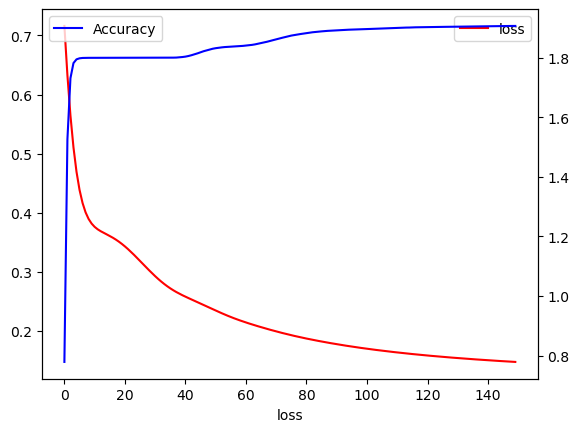

In [39]:
## 손실과 정확도 시각화
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(loss_accuracy[0], label = 'loss', color='red')
ax1.set_xlabel('loss')
ax2 = ax1.twinx()

ax2.plot(loss_accuracy[1], label = 'Accuracy', color='blue')

ax1.legend()
ax2.legend()
plt.xlabel('Epochs')
plt.show()